## Airline Chat Intent Classification

The dataset is from the ATIS Travel Information System and is widely used as a benchmark for Intent Classification.
Intent Classification is part of Natural Language Understanding(NLU) and is a necessary component of any chatbot. The dataset is already split into test and train, and has two columns, one of text and the other with its respective label. 
***

In [49]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import spatial
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers import Input, Dense
from keras.models import Sequential
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

''

In [58]:
train_data = pd.read_csv('atis-airlinetravelinformationsystem/atis_intents_train.csv')
test_data = pd.read_csv('atis-airlinetravelinformationsystem/atis_intents_test.csv')

In [59]:
#test_data.head
#train_data.describe

#### Data Preprocessing 

In [60]:
train_data.rename(columns={'atis_flight':'Label',' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning':'Text'}, inplace=True)
test_data.rename(columns={'atis_flight':'Label',' i would like to find a flight from charlotte to las vegas that makes a stop in st. louis':'Text'}, inplace=True)

words = set(stopwords.words('english'))
train_data['Text']=train_data['Text'].apply(lambda x:' '.join([word for word in x.split()if word not in (words)]))
train_data['Text']= train_data['Text'].str.replace('\d+','')
test_data['Text']=test_data['Text'].apply(lambda x:' '.join([word for word in x.split()if word not in (words)]))
test_data['Text']= test_data['Text'].str.replace('\d+','')


text = train_data['Text']
labels = train_data['Label']
test_text = test_data['Text']
test_labels = test_data['Label']

print('Renaming Columns, removing stopwords and numbers, seperating train and tests Labels and Text.')
print('Number of Classes : ',labels.nunique())
print('Number of training entries :',len(text.index))
print('Number of testing entries :',len(test_text.index))

Renaming Columns, removing stopwords and numbers, seperating train and tests Labels and Text.
Number of Classes :  8
Number of training entries : 4833
Number of testing entries : 799


In [61]:
from keras.preprocessing.text import Tokenizer
t= Tokenizer()
t.fit_on_texts(text)
print('Word Index/Vocabulary size :',len(t.word_index))
word_index = t.word_index

max_vocab_size = len(word_index)+1
input_length = 25
print('Max Input Size: 25 ')


train_data_tokens = t.texts_to_sequences(text)
train_input = pad_sequences(train_data_tokens, input_length)
test_data_tokens = t.texts_to_sequences(test_text)
test_input = pad_sequences(test_data_tokens,input_length)

print('Train: ',train_input.shape,' Test: ',test_input.shape)

Word Index/Vocabulary size : 631
Max Input Size: 25 
Train:  (4833, 25)  Test:  (799, 25)


In [62]:
label_transformer = preprocessing.LabelEncoder()
label_transformer.fit(labels)

from sklearn.externals import joblib
joblib.dump(label_transformer, 'atis-airlinetravelinformationsystem/label_encoder.pk1')

labels = label_transformer.transform(labels)
test_labels = label_transformer.transform(test_labels)

labels = to_categorical(np.asarray(labels))
test_labels = to_categorical(np.asarray(test_labels))

print('Encoding labels and saving encoder model so assignments are same across train and test datasets.')
print('Example of labels after encoding : ',labels[1])

Encoding labels and saving encoder model so assignments are same across train and test datasets.
Example of labels after encoding :  [0. 0. 0. 0. 0. 1. 0. 0.]


In [8]:
X_train, X_val, y_train, y_val  = train_test_split(train_input, labels, test_size=0.2, random_state=1)
print('Splitting train and test :',X_train.shape, X_val.shape, y_train.shape, y_val.shape )

Splitting train and test : (3866, 25) (967, 25) (3866, 8) (967, 8)


#### Extracting Word Embeddings and Creating a Embedding Matrix

In [9]:
embedded_dim = 300
embedded_index = dict()
with open ('glove.42B.300d.txt','r',encoding='utf8') as glove : 
    for line in glove:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:],dtype='float32')
        embedded_index[word] = vector
glove.close()

print('Glove dict size :' ,len(embedded_index))

embedded_matrix = np.zeros((max_vocab_size, embedded_dim))
for x , i in word_index.items():
    vector = embedded_index.get(x)
    if vector is not None:
        embedded_matrix[i] = vector

print('Embedded Matrix is ready to be loaded into Model ')


Glove dict size : 1917495
Embedded Matrix is ready to be loaded into Model 


#### Visualizing Word Embeddings Using T-SNE

In [10]:
def similarity_check(embedding):
    return sorted(embedded_index.keys(), key=lambda x: spatial.distance.euclidean(embedded_index[x],embedding))
example = similarity_check(embedded_index['flight'])[1:10]
print(example)

['plane', 'flying', 'airline', 'airplane', 'flights', 'pilots', 'fly', 'flew', 'appelectric']


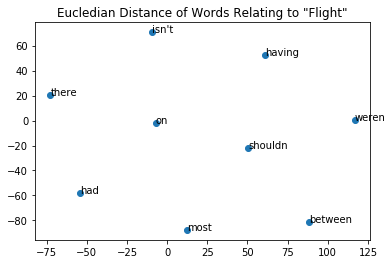

In [43]:
tsne = TSNE(n_components=2, random_state=0)
vectorized = [embedded_index[word] for words in example]
Y = tsne.fit_transform(vectorized)

fig, ax = plt.subplots()
ax.plot(Y[:, 0], Y[:, 1], 'o')
ax.set_title('Eucledian Distance of Words Relating to "Flight"')
for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
plt.show()

#### Creating our Model 

In [50]:
model = Sequential()
model.add(Embedding(max_vocab_size, 300, input_length= input_length, weights=[embedded_matrix],trainable=False))
model.add(Conv1D(filters=32, kernel_size=8, activation='selu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='selu'))
model.add(Dense(8, activation='sigmoid'))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 300)           189600    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 18, 32)            76832     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 9, 32)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2890      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 88        
Total params: 269,410
Trainable params: 79,810
Non-trainable params: 189,600
___________________________________________

In [51]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
model.fit(X_train,y_train, epochs=5, verbose=2)

Epoch 1/5
 - 6s - loss: 0.7200 - accuracy: 0.8163
Epoch 2/5
 - 3s - loss: 0.2461 - accuracy: 0.9346
Epoch 3/5
 - 3s - loss: 0.1135 - accuracy: 0.9747
Epoch 4/5
 - 3s - loss: 0.0544 - accuracy: 0.9899
Epoch 5/5
 - 3s - loss: 0.0277 - accuracy: 0.9961


In [52]:
model.evaluate(X_val,y_val)

967/967 [==============================] - 1s 543us/step


[0.14366027310821916, 0.9679421186447144]

In [53]:
def acc(y_true, y_pred):
    return np.equal(np.argmax(y_true, axis=-1), np.argmax(y_pred, axis=-1)).mean()
predictions = model.predict(test_input)
print('Accuracy score on testing data: ',acc(test_labels,predictions))

Accuracy score on testing data:  0.9824780976220275


#### Understanding The Classification Report

In [55]:
rounded_pred=np.argmax(predictions,axis=1)
rounded_labels=np.argmax(test_labels, axis=1)
print(classification_report(rounded_labels,rounded_pred))
print('We have 98% Accuray on testing data ! ')

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        33
           1       1.00      0.56      0.71         9
           2       0.98      0.92      0.95        48
           3       0.97      0.95      0.96        38
           4       0.99      0.99      0.99       631
           5       1.00      1.00      1.00         1
           6       0.97      1.00      0.99        36
           7       0.60      1.00      0.75         3

    accuracy                           0.98       799
   macro avg       0.93      0.93      0.91       799
weighted avg       0.98      0.98      0.98       799

We have 98% Accuray on testing data ! 
